# BB84 Protocol & Cascade Error Correction Visualization

This notebook visualizes the performance metrics of the BB84 Quantum Key Distribution protocol and the Cascade information reconciliation (error correction) protocol.
We analyze how the system performs under different conditions, specifically focusing on:
1.  **QBER (Quantum Bit Error Rate)**: Impact of Eavesdropping (Eve).
2.  **Key Yield**: Determining the "funnel of loss" from input qubits to final key.
3.  **Information Leakage**: How much information is revealed during error correction.
4.  **Reconciliation Efficiency**: How close the protocol gets to the theoretical Shannon limit.
5.  **Latency**: Channel uses required for reconciliation.
6.  **Eve Detection**: Relationship between intercept rate and QBER.

In [1]:
import asyncio
import random
import sys
import os
import math
import matplotlib.pyplot as plt
import numpy as np

# Ensure we can import from the local directory
sys.path.append(os.getcwd())

# Import our simulation classes
try:
    from bb84_server_client import AliceServer, BobClient, QuantumChannel, Detector, Eve, APIClient, Photon 
    from cascade_refactored import CascadeClientProtocol
except ImportError:
    # Fallback if running from a different root
    sys.path.append(os.path.join(os.getcwd(), 'ServerClientBB84'))
    from bb84_server_client import AliceServer, BobClient, QuantumChannel, Detector, Eve, APIClient, Photon
    from cascade_refactored import CascadeClientProtocol

# Enable inline plotting
%matplotlib inline

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
async def run_simulation_scenario(num_qubits=1000, 
                                  include_eve=False, 
                                  eve_intercept_rate=0.2, 
                                  optical_error_rate=0.01,
                                  verbose=False):
    """
    Runs a single BB84 simulation instance with the specified parameters.
    Returns the results dictionary from Bob's post-processing.
    """
    # Seeds for reproducibility (optional: pass a fixed seed if needed)
    seed_base = random.randint(1000, 99999)
    
    # 1. Create Objects
    # We create Channel first with None as next_actor, then link it.
    channel = QuantumChannel("Fiber", length_km=50, attenuation_db=0.2, 
                             optical_error_rate=optical_error_rate, next_actor=None, seed=seed_base+1)
    
    alice = AliceServer("Alice", channel, num_qubits=num_qubits, verbose=verbose, seed=seed_base+2)
    api = APIClient(alice)
    bob = BobClient("Bob", api, seed=seed_base+3)
    detector = Detector("Detector", efficiency=0.8, dark_count_prob=0.01, parent_bob=bob, seed=seed_base+4)
    
    # 2. Wire the Topology
    if include_eve:
        # Alice -> Channel -> Eve -> Detector -> Bob
        eve = Eve("Eve", next_actor=detector, intercept_rate=eve_intercept_rate, seed=seed_base+5)
        channel.next_actor = eve
        actors = [alice, channel, eve, detector, bob]
    else:
        # Alice -> Channel -> Detector -> Bob
        channel.next_actor = detector
        actors = [alice, channel, detector, bob]
        
    # 3. Start Actors
    tasks = [asyncio.create_task(a.start()) for a in actors]
    
    # 4. Run Protocol
    results = {}
    try:
        # Phase 1: Quantum Transmission
        await alice.run_quantum_transmission()
        
        # Wait for photons to propagate and be detected
        # Heuristic wait: 1.0s + some time per qubit if processing is slow
        await asyncio.sleep(0.5 + (num_qubits * 0.0002))
        
        # Phase 2: Classical Post-Processing (Sifting, Error Correction)
        results = await bob.run_classical_post_processing(num_qubits)
        
    except Exception as e:
        print(f"Simulation Error: {e}")
        import traceback
        traceback.print_exc()
    finally:
        # Stop all actors
        for a in actors:
            await a.send(a, ("STOP",))
            
        # Ensure tasks are cleaned up
        await asyncio.gather(*tasks)
        
    return results

# Test run
print("Running test simulation (100 qubits)...")
test_res = await run_simulation_scenario(num_qubits=100, verbose=False)
print("Test Result Keys:", test_res.keys())
print(f"QBER: {test_res.get('qber', 0):.2%}, Final Key: {test_res.get('final_length', 0)}")

Running test simulation (100 qubits)...

[BOB] Processing 10 detection events.
[BOB] First 15 Valid Detections: 1(x), 0(x), 0(+), 1(+), 0(x), 1(x), 0(+), 1(+), 1(+), 0(x) ...
[BOB] Sending 10 bases to Alice for sifting...
[BOB] Sifting complete. Bases matched on 3 events.
[BOB] Sifted Key Preview: [1, 0, 0]...
[BOB] Sampling 0 bits (20%) for QBER estimation...
[BOB] Not enough bits to sample. QBER set to 0.0
[BOB] Initializing Cascade Protocol...
Test Result Keys: dict_keys(['sifted_length', 'qber', 'final_length', 'revealed', 'corrected', 'channel_uses', 'corrected_key', 'exec_time'])
QBER: 0.00%, Final Key: 3


In [3]:
# --- Experiment 1: Scaling Analysis (Input Size vs Metrics) ---

# Increased range to show behavior at scale (up to 100k qubits)
# Note: This may take a few minutes to run.
qubit_counts = [5000, 10000, 50000, 100000, 500000, 1000000]
data_safe = {"counts": [], "qber": [], "yield": [], "leakage": [], "sifted": []}
data_attacked = {"counts": [], "qber": [], "yield": [], "leakage": [], "sifted": []}

print(f"Running Batch 1: Safe Scenario (No Eve)... [Points: {len(qubit_counts)}]")
for n in qubit_counts:
    print(f"  Simulating {n} qubits...", end="\r")
    # Small random jitter in optical error to simulate real physics variance
    res = await run_simulation_scenario(num_qubits=n, include_eve=False, optical_error_rate=0.01)
    
    data_safe["counts"].append(n)
    data_safe["qber"].append(res['qber'] * 100)
    data_safe["sifted"].append(res['sifted_length'])
    data_safe["yield"].append(res['final_length'])
    
    # Leakage Ratio = Revealed Bits / Sifted Key Length
    ratio = res['revealed'] / res['sifted_length'] if res['sifted_length'] > 0 else 0
    data_safe["leakage"].append(ratio * 100)

print("\nRunning Batch 2: Attacked Scenario (Eve Intercepts 20%)...")
for n in qubit_counts:
    print(f"  Simulating {n} qubits...", end="\r")
    res = await run_simulation_scenario(num_qubits=n, include_eve=True, eve_intercept_rate=0.20, optical_error_rate=0.01)
    
    data_attacked["counts"].append(n)
    data_attacked["qber"].append(res['qber'] * 100)
    data_attacked["sifted"].append(res['sifted_length'])
    data_attacked["yield"].append(res['final_length'])
    
    ratio = res['revealed'] / res['sifted_length'] if res['sifted_length'] > 0 else 0
    data_attacked["leakage"].append(ratio * 100)

print("\nData collection complete.")

Running Batch 1: Safe Scenario (No Eve)... [Points: 6]
  Simulating 5000 qubits...
[BOB] Processing 415 detection events.
[BOB] First 15 Valid Detections: 0(+), 1(x), 1(x), 0(x), 1(x), 1(x), 1(x), 0(+), 1(+), 1(+), 1(+), 1(x), 1(+), 0(x), 0(x) ...
[BOB] Sending 415 bases to Alice for sifting...
[BOB] Sifting complete. Bases matched on 219 events.
[BOB] Sifted Key Preview: [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0]...
[BOB] Sampling 43 bits (20%) for QBER estimation...
[BOB] QBER Analysis: 0 errors in 43 samples. Estimated QBER = 0.00%
[BOB] Discarding revealed bits. Working Key Size: 176
[BOB] Initializing Cascade Protocol...
  Simulating 10000 qubits...
[BOB] Processing 820 detection events.
[BOB] First 15 Valid Detections: 0(x), 1(+), 0(x), 1(x), 1(x), 1(x), 0(x), 1(+), 0(x), 0(x), 1(+), 1(x), 1(+), 1(x), 1(x) ...
[BOB] Sending 820 bases to Alice for sifting...
[BOB] Sifting complete. Bases matched on 394 events.
[BOB] Sifted Key Preview: [1, 1, 1, 0, 1, 0, 0, 1, 1,

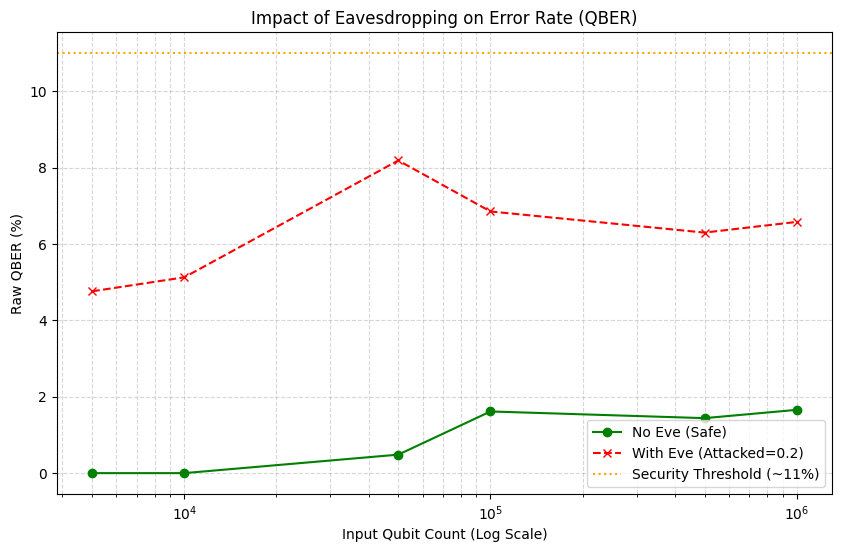

In [4]:
# --- Graph 1: QBER vs Input Qubit Count ---

plt.figure(figsize=(10, 6))
plt.plot(data_safe["counts"], data_safe["qber"], 'o-', color='green', label='No Eve (Safe)')
plt.plot(data_attacked["counts"], data_attacked["qber"], 'x--', color='red', label='With Eve (Attacked=0.2)')

plt.xscale('log')
plt.xlabel('Input Qubit Count (Log Scale)')
plt.ylabel('Raw QBER (%)')
plt.title('Impact of Eavesdropping on Error Rate (QBER)')
plt.legend()
plt.grid(True, which="both", linestyle='--', alpha=0.5)

# Add baseline threshold annotation
plt.axhline(y=11, color='orange', linestyle=':', label='Security Threshold (~11%)')
plt.legend()

plt.show()

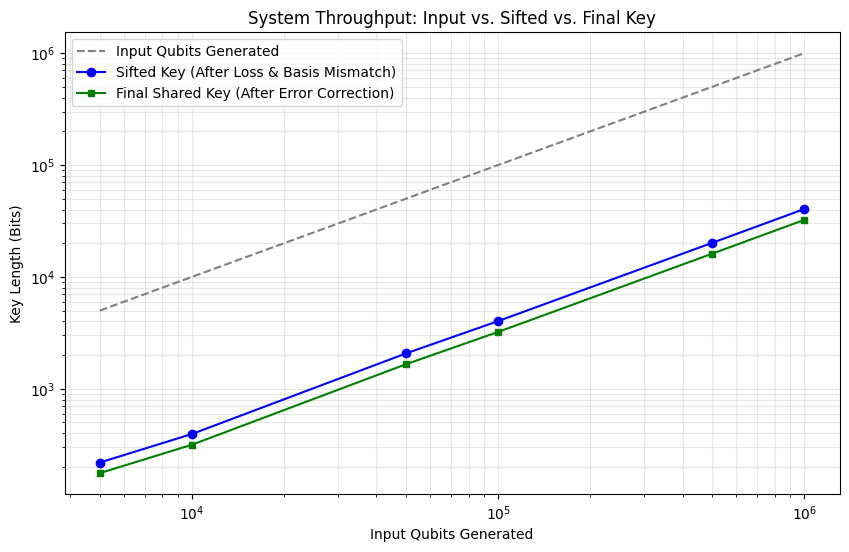

In [5]:
# --- Graph 2: The "Funnel of Loss" (Key Yield) ---

plt.figure(figsize=(10, 6))

# Plot Reference Line (Input)
plt.plot(qubit_counts, qubit_counts, '--', color='gray', label='Input Qubits Generated')

# Plot Sifted Key (Safe Scenario)
plt.plot(data_safe["counts"], data_safe["sifted"], 'o-', color='blue', label='Sifted Key (After Loss & Basis Mismatch)')

# Plot Final Key (Safe Scenario)
plt.plot(data_safe["counts"], data_safe["yield"], 's-', color='green', markersize=4, label='Final Shared Key (After Error Correction)')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Input Qubits Generated')
plt.ylabel('Key Length (Bits)')
plt.title('System Throughput: Input vs. Sifted vs. Final Key')
plt.legend()
plt.grid(True, which="both", alpha=0.3)

plt.show()

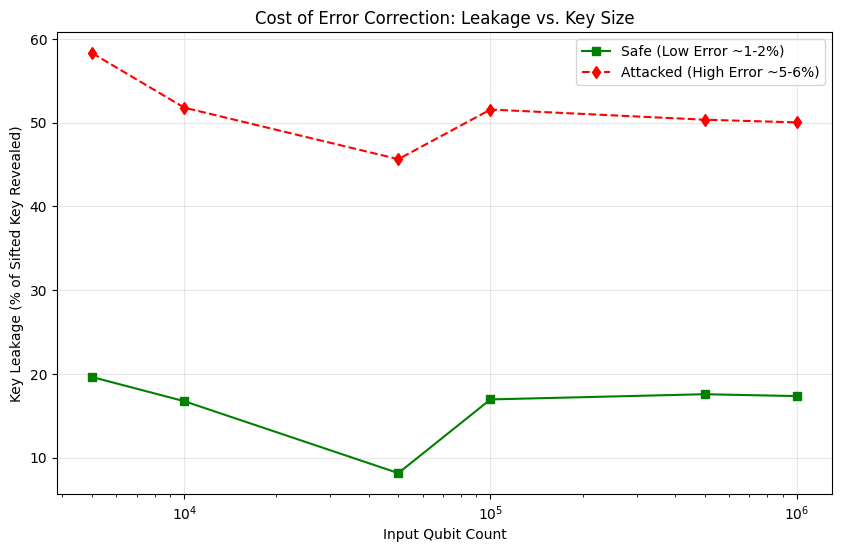

In [6]:
# --- Graph 3: Information Leakage during Cascade ---

plt.figure(figsize=(10, 6))

plt.plot(data_safe["counts"], data_safe["leakage"], 's-', color='green', label='Safe (Low Error ~1-2%)')
plt.plot(data_attacked["counts"], data_attacked["leakage"], 'd--', color='red', label='Attacked (High Error ~5-6%)')

plt.xscale('log')
plt.xlabel('Input Qubit Count')
plt.ylabel('Key Leakage (% of Sifted Key Revealed)')
plt.title('Cost of Error Correction: Leakage vs. Key Size')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [7]:
# --- Experiment 2: Reconciliation Efficiency vs QBER ---

def binary_entropy(p):
    """Calculates binary entropy H(p)."""
    if p <= 0 or p >= 1: return 0.0
    return -p * math.log2(p) - (1 - p) * math.log2(1 - p)

print("Running Efficiency Experiment (Sweeping Error Rate)...")

# Sweep from 1% to 25% error
error_rates = np.linspace(0, 0.25, 25) 
eff_results = {"qber": [], "efficiency": [], "revealed_bits": [], "sifted_length": [], "std_efficiency": []}

trials_per_error = 10

for err in error_rates:
    print(f"  Simulating Optical Error: {err:.3f}...", end="\r")
    
    res = await run_simulation_scenario(num_qubits=50000, include_eve=True, optical_error_rate=err)
    
    # Extract Metrics
    N_revealed = res['revealed']
    K_sifted = res['sifted_length']
    qber = res['qber']
    
    # Calculate Efficiency: η = N_revealed / (K_sifted * H(qber))
    if K_sifted > 0 and 0 < qber < 1:
        h_eps = binary_entropy(qber)
        if h_eps > 0:
            eta = N_revealed / (K_sifted * h_eps)
            
            eff_results["qber"].append(qber)
            eff_results["efficiency"].append(eta)
            eff_results["revealed_bits"].append(N_revealed)
            eff_results["sifted_length"].append(K_sifted)
    

print("\nEfficiency Data collected (averaged over 10 runs per point).")

Running Efficiency Experiment (Sweeping Error Rate)...
  Simulating Optical Error: 0.000...
[BOB] Processing 3841 detection events.
[BOB] First 15 Valid Detections: 1(+), 1(+), 0(x), 0(+), 0(x), 1(x), 1(x), 0(+), 0(x), 0(+), 1(+), 0(x), 1(+), 1(+), 1(+) ...
[BOB] Sending 3841 bases to Alice for sifting...
[BOB] Sifting complete. Bases matched on 1866 events.
[BOB] Sifted Key Preview: [1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0]...
[BOB] Sampling 373 bits (20%) for QBER estimation...
[BOB] QBER Analysis: 22 errors in 373 samples. Estimated QBER = 5.90%
[BOB] Discarding revealed bits. Working Key Size: 1493
[BOB] Initializing Cascade Protocol...
  Simulating Optical Error: 0.010...
[BOB] Processing 3994 detection events.
[BOB] First 15 Valid Detections: 0(x), 1(x), 0(x), 1(+), 0(+), 1(+), 0(+), 1(x), 0(x), 0(x), 0(+), 1(x), 0(x), 1(+), 1(x) ...
[BOB] Sending 3994 bases to Alice for sifting...
[BOB] Sifting complete. Bases matched on 1983 events.
[BOB] Sifted Key Preview: 

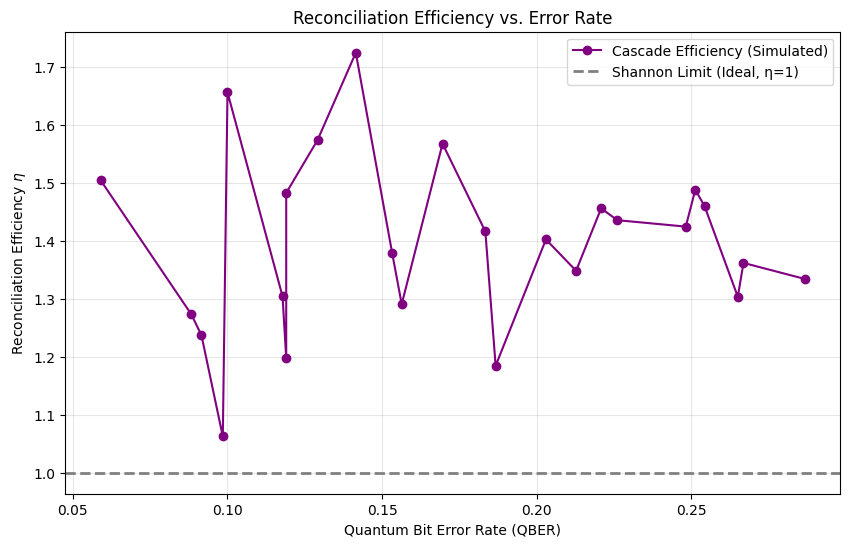

In [8]:
# --- Graph 4: Reconciliation Efficiency vs QBER ---

plt.figure(figsize=(10, 6))

if len(eff_results["qber"]) > 0:
    # Sort for clean line
    sorted_indices = np.argsort(eff_results["qber"])
    x_sorted = np.array(eff_results["qber"])[sorted_indices]
    y_sorted = np.array(eff_results["efficiency"])[sorted_indices]

    plt.plot(x_sorted, y_sorted, 'o-', color='purple', label='Cascade Efficiency (Simulated)')
else:
    print("No valid efficiency data points collected.")

# plt.plot(eff_results["qber"], eff_results["efficiency"], 'o-', color='purple', label='Cascade Efficiency (Simulated)')

# Theoretical limit line at 1.0
plt.axhline(y=1.0, color='gray', linestyle='--', linewidth=2, label='Shannon Limit (Ideal, η=1)')

# Add typical range annotation for Cascade
#plt.axhspan(1.05, 1.20, color='yellow', alpha=0.1, label='Typical Cascade Range')

plt.xlabel('Quantum Bit Error Rate (QBER)')
plt.ylabel(r'Reconciliation Efficiency $\eta$')
plt.title('Reconciliation Efficiency vs. Error Rate')
plt.legend()
plt.grid(True, alpha=0.3)
#plt.ylim(0.9, 1.5) # Focus on the relevant range

plt.show()

Running Latency Experiment...
  Scenario: Low Error (1%)...

[BOB] Processing 12 detection events.
[BOB] First 15 Valid Detections: 0(+), 0(x), 1(x), 0(+), 1(+), 1(+), 1(+), 1(x), 0(x), 1(+), 1(x), 1(x) ...
[BOB] Sending 12 bases to Alice for sifting...
[BOB] Sifting complete. Bases matched on 8 events.
[BOB] Sifted Key Preview: [0, 1, 0, 1, 1, 0, 1, 1]...
[BOB] Sampling 1 bits (20%) for QBER estimation...
[BOB] QBER Analysis: 0 errors in 1 samples. Estimated QBER = 0.00%
[BOB] Discarding revealed bits. Working Key Size: 7
[BOB] Initializing Cascade Protocol...

[BOB] Processing 41 detection events.
[BOB] First 15 Valid Detections: 1(+), 0(+), 0(+), 0(x), 0(x), 0(x), 0(+), 0(x), 0(+), 0(x), 0(+), 0(x), 1(+), 1(x), 1(x) ...
[BOB] Sending 41 bases to Alice for sifting...
[BOB] Sifting complete. Bases matched on 25 events.
[BOB] Sifted Key Preview: [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1]...
[BOB] Sampling 5 bits (20%) for QBER estimation...
[BOB] QBER Analysis: 0 erro

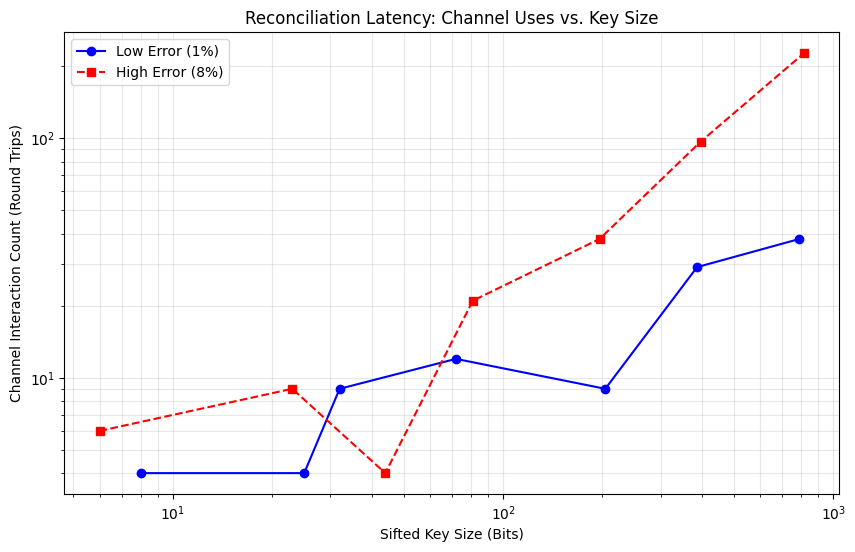

In [9]:
# --- Experiment 3: Channel Latency (Round Trips vs Key Size) ---

print("Running Latency Experiment...")
input_sizes = [200, 500, 1000, 2000, 5000, 10000, 20000]

latency_low = {"size": [], "uses": []}
latency_high = {"size": [], "uses": []}

# Low Error (1%)
print("  Scenario: Low Error (1%)...")
for n in input_sizes:
    res = await run_simulation_scenario(num_qubits=n, optical_error_rate=0.01)
    if res['sifted_length'] > 0:
        latency_low["size"].append(res['sifted_length'])
        latency_low["uses"].append(res['channel_uses'])

# High Error (8%)
print("  Scenario: High Error (8%)...")
for n in input_sizes:
    res = await run_simulation_scenario(num_qubits=n, optical_error_rate=0.08)
    if res['sifted_length'] > 0:
        latency_high["size"].append(res['sifted_length'])
        latency_high["uses"].append(res['channel_uses'])

# --- Graph 5: Channel Uses ---

plt.figure(figsize=(10, 6))
plt.plot(latency_low["size"], latency_low["uses"], 'o-', color='blue', label='Low Error (1%)')
plt.plot(latency_high["size"], latency_high["uses"], 's--', color='red', label='High Error (8%)')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sifted Key Size (Bits)')
plt.ylabel('Channel Interaction Count (Round Trips)')
plt.title('Reconciliation Latency: Channel Uses vs. Key Size')
plt.legend()
plt.grid(True, which="both", alpha=0.3)

plt.show()

Running Eve Detection Experiment...
  Simulating Intercept Rate: 0.00...
[BOB] Processing 396 detection events.
[BOB] First 15 Valid Detections: 0(+), 1(x), 0(x), 0(x), 1(+), 0(+), 1(x), 0(x), 0(x), 1(+), 0(+), 1(+), 1(x), 1(x), 0(x) ...
[BOB] Sending 396 bases to Alice for sifting...
[BOB] Sifting complete. Bases matched on 217 events.
[BOB] Sifted Key Preview: [0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]...
[BOB] Sampling 43 bits (20%) for QBER estimation...
[BOB] QBER Analysis: 0 errors in 43 samples. Estimated QBER = 0.00%
[BOB] Discarding revealed bits. Working Key Size: 174
[BOB] Initializing Cascade Protocol...
  Simulating Intercept Rate: 0.05...
[BOB] Processing 380 detection events.
[BOB] First 15 Valid Detections: 0(x), 0(x), 0(x), 1(x), 0(x), 0(+), 0(+), 0(x), 0(+), 1(+), 0(+), 1(+), 0(x), 0(+), 1(x) ...
[BOB] Sending 380 bases to Alice for sifting...
[BOB] Sifting complete. Bases matched on 183 events.
[BOB] Sifted Key Preview: [1, 0, 0, 0, 1, 0, 0, 0, 1, 0

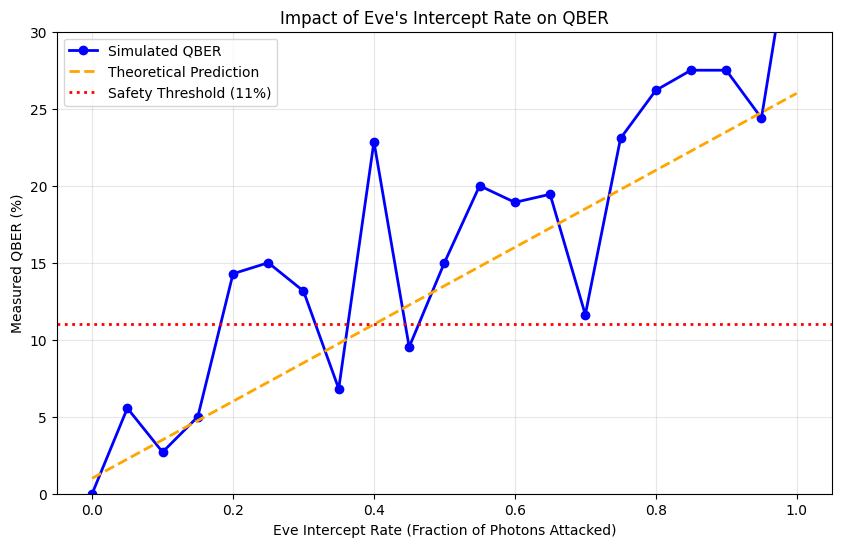

In [10]:
# --- Experiment 4: Eve Detection (Intercept Rate vs QBER) ---

print("Running Eve Detection Experiment...")
intercept_rates = np.linspace(0.0, 1.0, 21)
measured_qbers = []
theory_qbers = []
optical_err = 0.01

for rate in intercept_rates:
    print(f"  Simulating Intercept Rate: {rate:.2f}...", end="\r")
    # 5000 qubits for decent stats
    res = await run_simulation_scenario(num_qubits=5000, include_eve=True, eve_intercept_rate=rate, optical_error_rate=optical_err)
    measured_qbers.append(res['qber'] * 100)
    
    # Theoretical QBER = Base Error + (25% * Intercept Rate)
    # Factor is 0.25 because Eve chooses wrong basis 50% of time, and resends state that has 50% error probability in Bob's basis.
    theory = (optical_err + (0.25 * rate)) * 100
    theory_qbers.append(theory)

# --- Graph 6: Eve Intercept vs QBER ---

plt.figure(figsize=(10, 6))

plt.plot(intercept_rates, measured_qbers, 'o-', color='blue', linewidth=2, label='Simulated QBER')
plt.plot(intercept_rates, theory_qbers, '--', color='orange', linewidth=2, label='Theoretical Prediction')

# Safety Threshold (Typical QBER limit ~11%)
plt.axhline(y=11, color='red', linestyle=':', linewidth=2, label='Safety Threshold (11%)')

plt.xlabel('Eve Intercept Rate (Fraction of Photons Attacked)')
plt.ylabel('Measured QBER (%)')
plt.title('Impact of Eve\'s Intercept Rate on QBER')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 30)

plt.show()

Running Latency vs Error Rate check (with Averaging)...
  Simulating Mean Uses for Error: 0.010...
[BOB] Processing 155 detection events.
[BOB] First 15 Valid Detections: 1(x), 1(+), 1(x), 0(x), 1(x), 0(x), 1(x), 0(x), 0(+), 0(x), 0(x), 1(x), 1(+), 1(x), 1(x) ...
[BOB] Sending 155 bases to Alice for sifting...
[BOB] Sifting complete. Bases matched on 91 events.
[BOB] Sifted Key Preview: [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]...
[BOB] Sampling 18 bits (20%) for QBER estimation...
[BOB] QBER Analysis: 0 errors in 18 samples. Estimated QBER = 0.00%
[BOB] Discarding revealed bits. Working Key Size: 73
[BOB] Initializing Cascade Protocol...

[BOB] Processing 165 detection events.
[BOB] First 15 Valid Detections: 1(x), 0(x), 0(x), 1(x), 1(+), 1(x), 0(x), 0(x), 0(x), 1(x), 1(x), 0(x), 0(+), 0(x), 0(x) ...
[BOB] Sending 165 bases to Alice for sifting...
[BOB] Sifting complete. Bases matched on 71 events.
[BOB] Sifted Key Preview: [1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

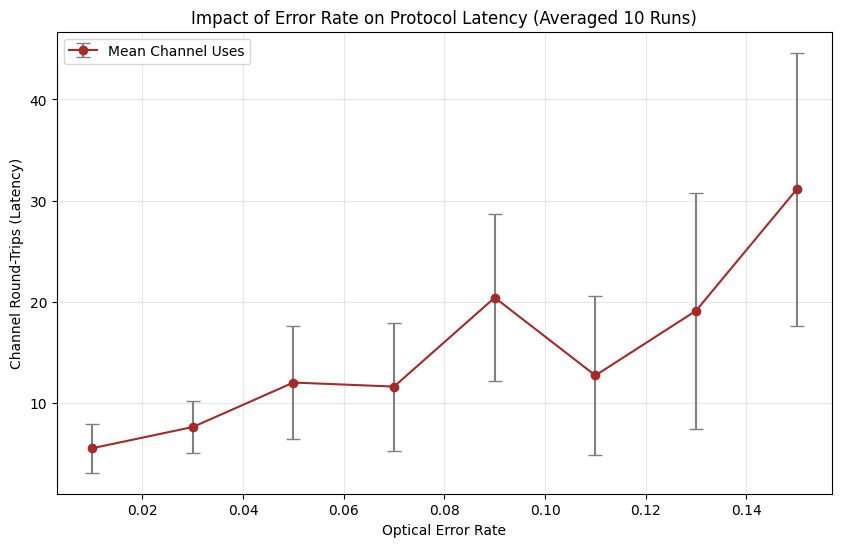

In [11]:
# --- Graph 5b: Channel Uses vs QBER (Scientific Visualization) ---

print("Running Latency vs Error Rate check (with Averaging)...")
err_rates = np.linspace(0.01, 0.15, 8) # Fewer points but averaged
avg_uses = []
std_uses = []
valid_errs = []

trials_per_point = 10

for err in err_rates:
    print(f"  Simulating Mean Uses for Error: {err:.3f}...", end="\r")
    uses_samples = []
    
    for _ in range(trials_per_point):
        res = await run_simulation_scenario(num_qubits=2000, optical_error_rate=err)
        if res['sifted_length'] > 0:
            uses_samples.append(res['channel_uses'])
            
    if uses_samples:
        avg_uses.append(np.mean(uses_samples))
        std_uses.append(np.std(uses_samples))
        valid_errs.append(err)

plt.figure(figsize=(10, 6))

# Plot with Error Bars to show variance
plt.errorbar(valid_errs, avg_uses, yerr=std_uses, fmt='o-', color='brown', ecolor='gray', capsize=5, label='Mean Channel Uses')

plt.xlabel('Optical Error Rate')
plt.ylabel('Channel Round-Trips (Latency)')
plt.title(f'Impact of Error Rate on Protocol Latency (Averaged {trials_per_point} Runs)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()